In [1]:
import os, glob
os.listdir()

['trans_new.parquet',
 'client.csv',
 'account.csv',
 'loan.csv',
 'trans_df.parquet',
 'disp.csv',
 'district.csv',
 'card.csv',
 'new_challenge.ipynb',
 'trans.csv',
 '.ipynb_checkpoints',
 'order.csv',
 'spark-warehouse',
 'test.ipynb']

In [2]:
# read all csv as pyspark dataframes
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

account_df = spark.read.csv("account.csv",header=True,sep=";")
client_df = spark.read.csv("client.csv",header=True,sep=";")
loan_df = spark.read.csv("loan.csv",header=True,sep=";")
disp_df = spark.read.csv("disp.csv",header=True,sep=";")
district_df = spark.read.csv("district.csv",header=True,sep=";")
card_df = spark.read.csv("card.csv",header=True,sep=";")
trans_df = spark.read.csv("trans.csv",header=True,sep=";")
order_df = spark.read.csv("order.csv",header=True,sep=";")

In [3]:
trans_df

DataFrame[trans_id: string, account_id: string, date: string, type: string, operation: string, amount: string, balance: string, k_symbol: string, branch: string, bank: string, account: string]

In [4]:
# dates are of string type
trans_df.select('date').collect()

[Row(date='1998-05-31'),
 Row(date='1998-01-09'),
 Row(date='1996-11-30'),
 Row(date='1996-10-28'),
 Row(date='1998-07-30'),
 Row(date='1995-06-07'),
 Row(date='1997-12-03'),
 Row(date='1997-01-13'),
 Row(date='1994-04-30'),
 Row(date='1997-02-05'),
 Row(date='1996-12-31'),
 Row(date='1997-06-01'),
 Row(date='1996-03-05'),
 Row(date='1997-10-12'),
 Row(date='1996-09-13'),
 Row(date='1998-08-17'),
 Row(date='1997-11-12'),
 Row(date='1998-10-31'),
 Row(date='1996-05-06'),
 Row(date='1997-05-05'),
 Row(date='1997-03-10'),
 Row(date='1998-08-14'),
 Row(date='1998-12-14'),
 Row(date='1995-04-09'),
 Row(date='1995-08-31'),
 Row(date='1997-01-31'),
 Row(date='1998-06-05'),
 Row(date='1997-02-28'),
 Row(date='1997-04-30'),
 Row(date='1995-10-27'),
 Row(date='1997-08-05'),
 Row(date='1997-06-30'),
 Row(date='1995-03-14'),
 Row(date='1995-04-09'),
 Row(date='1997-03-21'),
 Row(date='1997-12-08'),
 Row(date='1997-03-12'),
 Row(date='1997-11-17'),
 Row(date='1998-12-06'),
 Row(date='1994-10-20'),


In [5]:
# shape of trans file
trans_df.count()

1056410

In [6]:
# list data types of trans
trans_df.describe()

DataFrame[summary: string, trans_id: string, account_id: string, date: string, type: string, operation: string, amount: string, balance: string, k_symbol: string, branch: string, bank: string, account: string]

In [7]:
trans_df.head(n=3)

[Row(trans_id='967842', account_id='1532', date='1998-05-31', type='PRIJEM', operation=None, amount='253', balance='62661', k_symbol='UROK', branch='AR', bank=None, account='0'),
 Row(trans_id='271012', account_id='1499', date='1998-01-09', type='PRIJEM', operation='VKLAD', amount='5500', balance='49790', k_symbol=None, branch='AR', bank=None, account='0'),
 Row(trans_id='971490', account_id='1645', date='1996-11-30', type='PRIJEM', operation=None, amount='43', balance='19460', k_symbol='UROK', branch='AR', bank=None, account='0')]

In [8]:
# cast the right types for some columns in trans_df
from pyspark.sql.functions import to_date
from pyspark.sql.types import IntegerType
trans_df = trans_df.withColumn('date', to_date(trans_df.date, 'yyyy-MM-dd'))
trans_df = trans_df.withColumn('balance', trans_df.balance.cast(IntegerType()))
trans_df = trans_df.withColumn('amount', trans_df.amount.cast(IntegerType()))
trans_df = trans_df.withColumn('account', trans_df.account.cast(IntegerType()))
trans_df = trans_df.withColumn('trans_id', trans_df.trans_id.cast(IntegerType()))
trans_df = trans_df.withColumn('account_id', trans_df.account_id.cast(IntegerType()))

In [9]:
# by ordering the data we can see that there are null values
trans_df.orderBy('date').show(n=10)

+--------+----------+----+------+-------------+------+-------+--------+------+----+--------+
|trans_id|account_id|date|  type|    operation|amount|balance|k_symbol|branch|bank| account|
+--------+----------+----+------+-------------+------+-------+--------+------+----+--------+
|  525741|      2913|null|PRIJEM|PREVOD Z UCTU|  4471|  14604|  DUCHOD|    AK|  UV|21839374|
|   76222|       411|null| VYDAJ|        VYBER|    15|  69989|  SLUZBY|    AK|null|       0|
|  355590|      1962|null| VYDAJ|        VYBER| 11000|  44300|    null|    AK|null|       0|
|  283673|      1566|null| VYDAJ|        VYBER|  3240|  20009|    null|    AK|null|       0|
|  333397|      1836|null| VYDAJ|        VYBER|    15|  23532|  SLUZBY|    AK|null|       0|
|  991314|      2258|null|PRIJEM|         null|   151|  38086|    UROK|    AK|null|       0|
|   62601|       346|null| VYDAJ|        VYBER|    15|  42621|  SLUZBY|    AK|null|       0|
|  592467|      3287|null| VYDAJ|        VYBER|  3000|  40696|    null

In [10]:
# number of null values for each column in trans_df
import pyspark.sql.functions as F
df = trans_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for (c,c_type) in trans_df.dtypes]).toPandas()
df

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,branch,bank,account
0,0,0,3141,0,183126,0,0,535359,0,782875,0


In [11]:
trans_df.describe().toPandas()

,summary,trans_id,account_id,type,operation,amount,balance,k_symbol,branch,bank,account
0,count,1056410,1056410,1056410,873284,1056410,1056410,521051,1056410,273535,1056410
1,mean,528203.844466637,2937.6251654187295,None,None,5924.133402750826,38519.28087579633,None,None,None,1.277151986812128E7
2,stddev,304958.79211414634,2478.6011779840896,None,None,9522.338864724921,22119.024295304254,None,None,None,2.6136224149202265E7
3,min,1,1,PRIJEM,PREVOD NA UCET,0,-41126,DUCHOD,AK,AB,0
4,max,1056406,12376,VYDAJ,VYBER KARTOU,87400,209637,UVER,AR,YZ,99994199


In [12]:
[c[0] for c in trans_df.dtypes]

['trans_id',
 'account_id',
 'date',
 'type',
 'operation',
 'amount',
 'balance',
 'k_symbol',
 'branch',
 'bank',
 'account']

In [13]:
trans_df.agg({c[0]:'mean' for c in trans_df.dtypes if c[0] in ['amount', 'balance']}).show()

+-----------------+-----------------+
|      avg(amount)|     avg(balance)|
+-----------------+-----------------+
|5924.133402750826|38519.28087579633|
+-----------------+-----------------+



In [14]:
trans_df.agg({c[0]:'variance' for c in trans_df.dtypes if c[0] in ['amount', 'balance']}).show()

+-------------------+-------------------+
|   variance(amount)|  variance(balance)|
+-------------------+-------------------+
|9.067493745465069E7|4.892512357762599E8|
+-------------------+-------------------+



In [15]:
trans_df.agg({c[0]:'stddev' for c in trans_df.dtypes if c[0] in ['amount', 'balance']}).show()

+-----------------+------------------+
|   stddev(amount)|   stddev(balance)|
+-----------------+------------------+
|9522.338864724921|22119.024295304254|
+-----------------+------------------+



In [16]:
# group by k_symbol and compute mean for amount and balance
trans_df.groupby('k_symbol').agg({c : 'mean' for c in ['amount','balance']}).show()

+-----------+------------------+------------------+
|   k_symbol|       avg(amount)|      avg(balance)|
+-----------+------------------+------------------+
|SANKC. UROK|23.928979074191503|5718.1915028535195|
|       null|10240.607338253396| 41772.64050665068|
|   POJISTNE|1307.0885309696248|38185.817371095014|
|     DUCHOD|5520.3299713240385| 26046.94475757276|
|       SIPO| 4222.497713414634| 34299.01213584011|
|       UROK|150.28613086071886| 36124.61139870909|
|     SLUZBY|18.213691721314632| 35768.78778409456|
|       UVER| 4068.722921728886|42943.758338855754|
+-----------+------------------+------------------+



In [17]:
# group by operation and compute mean for amount and balance
trans_df.groupby('operation').agg({c : 'mean' for c in ['amount','balance']}).show()

+--------------+------------------+------------------+
|     operation|       avg(amount)|      avg(balance)|
+--------------+------------------+------------------+
|         VKLAD| 15429.07301249091| 50108.41681870957|
|          null|150.28613086071886| 36124.61139870909|
| PREVOD Z UCTU|11980.681526904798|  35637.5822780929|
|  VYBER KARTOU| 2262.753203134718| 53275.50454036572|
|PREVOD NA UCET|3229.6256948911696| 35414.50213147965|
|         VYBER| 5379.368026577462|36997.226377441344|
+--------------+------------------+------------------+



In [18]:
# group by k_symbol and compute variance for amount and balance
trans_df.groupby('k_symbol').agg({c : 'variance' for c in ['amount','balance']}).show()

+-----------+-------------------+--------------------+
|   k_symbol|   variance(amount)|   variance(balance)|
+-----------+-------------------+--------------------+
|SANKC. UROK| 1733.8870848073025| 2.956178719582273E8|
|       null|1.349928193069323E8| 5.728934863810161E8|
|   POJISTNE|  3251455.143342864|  3.80090066428726E8|
|     DUCHOD|  759463.6692483705| 9.345290301646177E7|
|       SIPO|  8571979.218941402| 3.645850745211722E8|
|       UROK|  7821.942035850668|3.9975076186920017E8|
|     SLUZBY|  4692.558018701901|3.8557204912325495E8|
|       UVER|  4733753.270571014|4.9975872357340646E8|
+-----------+-------------------+--------------------+



In [19]:
# group by operation and compute variance for amount and balance
trans_df.groupby('operation').agg({c : 'variance' for c in ['amount','balance']}).show()

+--------------+--------------------+--------------------+
|     operation|    variance(amount)|   variance(balance)|
+--------------+--------------------+--------------------+
|         VKLAD| 1.449866304715791E8| 8.017790174123753E8|
|          null|   7821.942035850668|3.9975076186920017E8|
| PREVOD Z UCTU|2.0003629259170008E8| 5.819190379782954E8|
|  VYBER KARTOU|     1481541.6502059|4.0701607675809735E8|
|PREVOD NA UCET|    7393501.14326321|3.8050036751418734E8|
|         VYBER| 7.828976258703987E7| 3.909903831781573E8|
+--------------+--------------------+--------------------+



In [20]:
# cast types for account table
account_df = account_df.withColumn('date', to_date(account_df.date, 'yyyy-MM-dd'))
account_df = account_df.withColumn('district_id', account_df.district_id.cast(IntegerType()))
account_df = account_df.withColumn('account_id', account_df.account_id.cast(IntegerType()))

In [21]:
account_df

DataFrame[account_id: int, district_id: int, frequency: string, date: date]

In [22]:
# join transactions and account table on account_id
inner_join = trans_df.join(account_df, trans_df.account_id == account_df.account_id)
inner_join.show()

+--------+----------+----------+------+--------------+------+-------+--------+------+----+--------+----------+-----------+----------------+----------+
|trans_id|account_id|      date|  type|     operation|amount|balance|k_symbol|branch|bank| account|account_id|district_id|       frequency|      date|
+--------+----------+----------+------+--------------+------+-------+--------+------+----+--------+----------+-----------+----------------+----------+
|  967842|      1532|1998-05-31|PRIJEM|          null|   253|  62661|    UROK|    AR|null|       0|      1532|         54|POPLATEK MESICNE|1996-09-19|
|  271012|      1499|1998-01-09|PRIJEM|         VKLAD|  5500|  49790|    null|    AR|null|       0|      1499|         47|POPLATEK MESICNE|1993-11-28|
|  971490|      1645|1996-11-30|PRIJEM|          null|    43|  19460|    UROK|    AR|null|       0|      1645|         50|POPLATEK MESICNE|1996-10-16|
|  605699|      3366|1996-10-28| VYDAJ|         VYBER|  9300|  38433|    null|    AR|null|    

In [23]:
# filter the joined table for cash withdrawals
vyber = inner_join.filter(inner_join['operation'] == 'VYBER').persist()
# find max amount of cash withdrawal
vyber_max_amount = vyber.agg(F.max('amount')).collect()[0][0]
# return the district_id for the max cash withdrawal
vyber_district_id_max_amount = vyber.filter(vyber['amount'] == vyber_max_amount).select('district_id', 'amount')
# find the name of the district by corresponding district_id in the district table
district_df.filter(district_df['district_id']=='47').select('district_id','A2').show()

# inner_join.show()
# print(grouped[0][0])

+-----------+---------+
|district_id|       A2|
+-----------+---------+
|         47|Pardubice|
+-----------+---------+



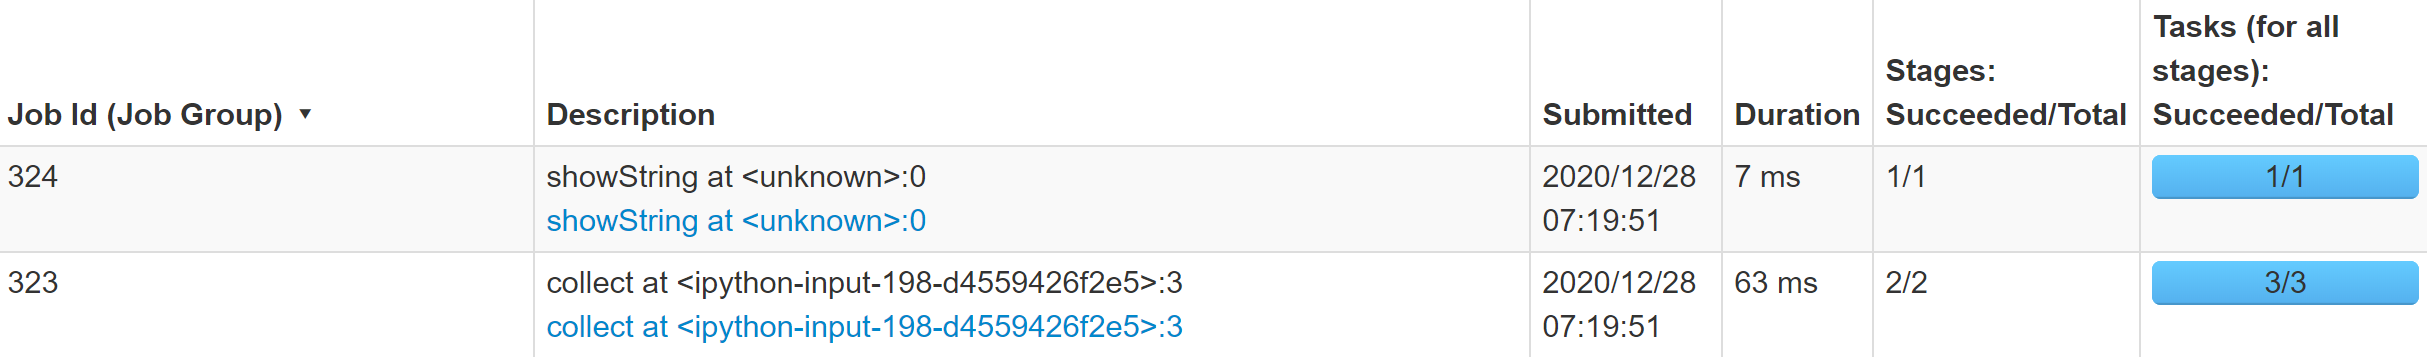

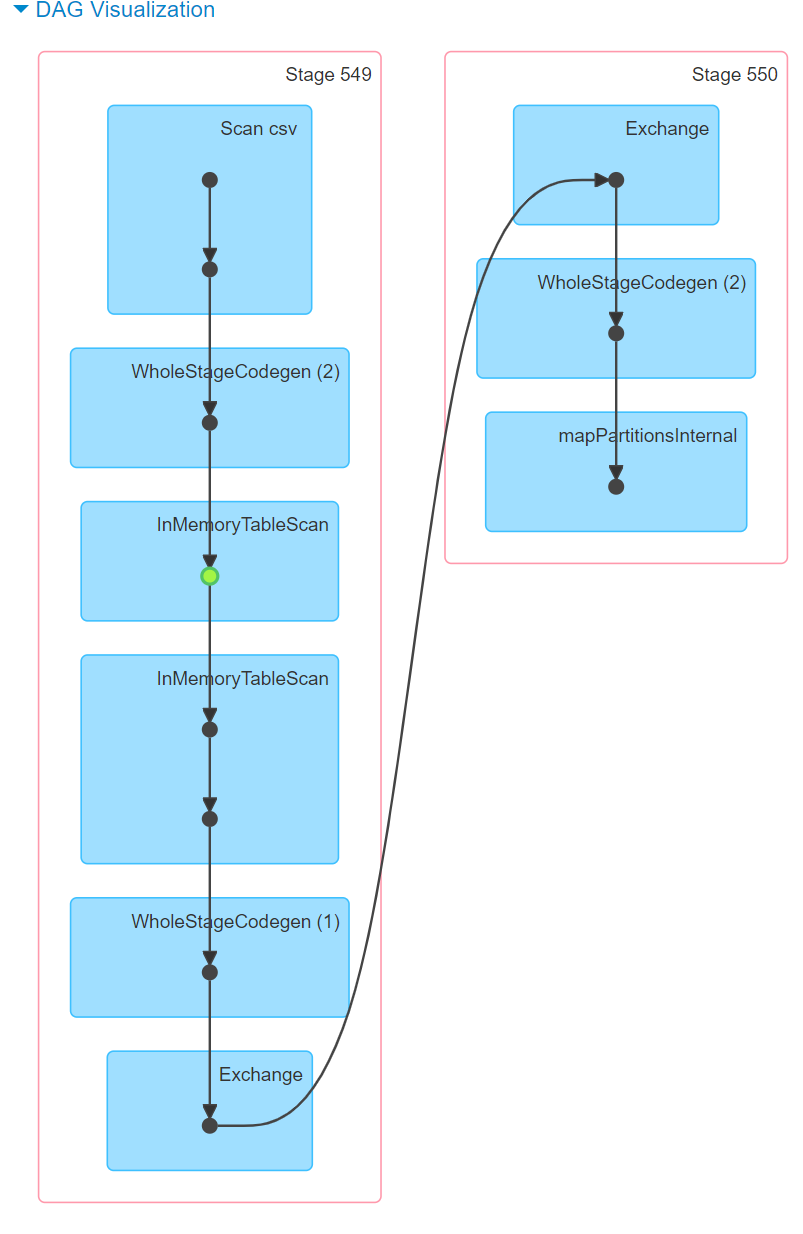



In [291]:
# find the number of cash withdrawals per district_id
district_id_cash_withdrawal = inner_join.filter(inner_join['operation'] == 'VYBER').groupBy(inner_join['district_id']).count().withColumnRenamed('count','cash_withdrawals_vol')
# join district names and #_of_inhabitants with cash outflows
cash_withdraw_per_district = district_id_cash_withdrawal.join(district_df, 'district_id').select('district_id','A2','cash_withdrawals_vol','A4')\
.withColumnRenamed('A2','district').withColumnRenamed('A4','number_of_inhabitants')
# cash_withdraw_per_district['#_of_inhabitants']
# convert field #_of_inhabitants to integer
cash_withdraw_per_district = cash_withdraw_per_district.withColumn('number_of_inhabitants', cash_withdraw_per_district.number_of_inhabitants.cast(IntegerType()))
# cash_withdraw_per_district.count()
# cash_withdraw_per_district.show(n=10)
cash_withdraw_per_district.show(n=10)

+-----------+-------------+--------------------+---------------------+
|district_id|     district|cash_withdrawals_vol|number_of_inhabitants|
+-----------+-------------+--------------------+---------------------+
|         31|       Tachov|                5382|                51313|
|         65|       Znojmo|                3549|               114200|
|         53|      Blansko|                4622|               107911|
|         34|     Chomutov|                3056|               125236|
|         28|Plzen - sever|                4308|                72541|
|         76|      Sumperk|                5501|               127369|
|         27|  Plzen - jih|                3551|                67298|
|         26|Plzen - mesto|                3772|               170449|
|         44|      Chrudim|                4684|               105606|
|         12|      Pribram|                3844|               107870|
+-----------+-------------+--------------------+---------------------+
only s

In [32]:
# get list from dataframe
x1 = cash_withdraw_per_district.select('cash_withdrawals_vol').rdd.flatMap(lambda x: x).collect()
x2 = cash_withdraw_per_district.select('number_of_inhabitants').rdd.flatMap(lambda x: x).collect()

In [33]:
from pyspark import SparkContext
from pyspark.mllib.stat import Statistics
    
sc = SparkContext.getOrCreate()
cash_withdrawal_vol = sc.parallelize(x1,2)
number_of_inhabitants = sc.parallelize(x2,2)

# calculate pearson correlation
pearson_corr = Statistics.corr(cash_withdrawal_vol, number_of_inhabitants,'pearson')
# calculate spearman correlation
spearman_corr = Statistics.corr(cash_withdrawal_vol, number_of_inhabitants,'spearman')
pearson_corr, spearman_corr

(0.96118764641878, 0.34733915650335134)

Text(0, 0.5, 'Number of inhabitants')

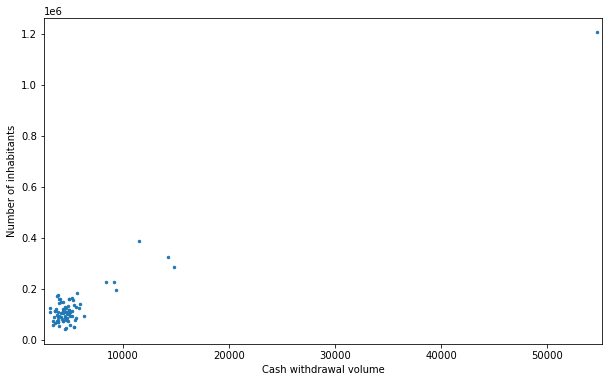

In [53]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,6))
ax.margins(x=0.01)
plt.scatter(x1,x2,s=6)
plt.xlabel('Cash withdrawal volume')
plt.ylabel('Number of inhabitants')

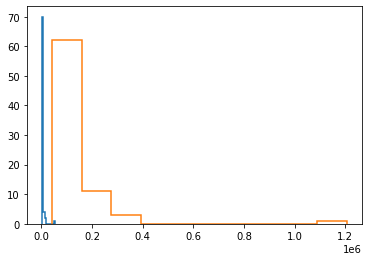

In [42]:
from matplotlib.pyplot import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(x1,lw=1.5,histtype='step', label = 'cash_withdrawal_vol')
ax.hist(x2,lw=1.5,histtype='step', label = 'number of inhabitants')
plt.show()

In [136]:
from pyspark.sql.functions import to_date
client_df = spark.read.csv('client.csv',sep=';',header=True,inferSchema=True)
client_df = client_df.select('client_id', 'gender', 'district_id', to_date('birth_date','yyyy-MM-dd').alias('birth_date'))
client_df

DataFrame[client_id: int, gender: string, district_id: int, birth_date: date]

In [137]:
client_ids_df = client_df.select(client_df['client_id'])
client_ids_list = client_ids_df.rdd.flatMap(lambda x: x).collect()
client_df

DataFrame[client_id: int, gender: string, district_id: int, birth_date: date]

In [148]:
# create new client_id with sha256 hash
from pyspark.sql.functions import sha2, concat_ws
new_client_df = client_df.withColumn('new_client_id',sha2(concat_ws('||',*client_df.columns),256))
# new_client_df.show()
type(new_client_df)

pyspark.sql.dataframe.DataFrame

In [149]:
from pyspark.sql.functions import to_date
disp_df = spark.read.csv('disp.csv',sep=';',header=True,inferSchema=True)
disp_df = disp_df.select('client_id', 'disp_id', 'account_id', 'type')
disp_df

DataFrame[client_id: int, disp_id: int, account_id: int, type: string]

In [154]:
new_disp_df = new_client_df.join(disp_df, new_client_df.client_id==disp_df.client_id)
new_disp_df.show()

+---------+------+-----------+----------+--------------------+---------+-------+----------+---------+
|client_id|gender|district_id|birth_date|       new_client_id|client_id|disp_id|account_id|     type|
+---------+------+-----------+----------+--------------------+---------+-------+----------+---------+
|        1|     F|         18|1970-12-13|0c38f954eaf3c911d...|        1|      1|         1|    OWNER|
|        2|     M|          1|1945-02-04|07324e34b3b1beb17...|        2|      2|         2|    OWNER|
|        3|     F|          1|1940-10-09|f1932ef987dd495de...|        3|      3|         2|DISPONENT|
|        4|     M|          5|1956-12-01|5b4d3fc1190776edd...|        4|      4|         3|    OWNER|
|        5|     F|          5|1960-07-03|0125ff849111a9785...|        5|      5|         3|DISPONENT|
|        6|     M|         12|1919-09-22|7e0cbb1e37ab530b8...|        6|      6|         4|    OWNER|
|        7|     M|         15|1929-01-25|5d309606dd62a5cda...|        7|      7|  

In [163]:
loan_df = spark.read.csv('loan.csv', inferSchema=True, header=True, sep=';')
loan_df.show()

+-------+----------+----------+------+--------+--------+------+
|loan_id|account_id|      date|amount|duration|payments|status|
+-------+----------+----------+------+--------+--------+------+
|   4959|         2|1994-01-05| 80952|      24|  3373.0|     A|
|   4961|        19|1996-04-29| 30276|      12|  2523.0|     B|
|   4962|        25|1997-12-08| 30276|      12|  2523.0|     A|
|   4967|        37|1998-10-14|318480|      60|  5308.0|     D|
|   4968|        38|1998-04-19|110736|      48|  2307.0|     C|
|   4973|        67|1996-05-02|165960|      24|  6915.0|     A|
|   4986|        97|1997-08-10|102876|      12|  8573.0|     A|
|   4988|       103|1997-12-06|265320|      36|  7370.0|     D|
|   4989|       105|1998-12-05|352704|      48|  7348.0|     C|
|   4990|       110|1997-09-08|162576|      36|  4516.0|     C|
|   4996|       132|1996-11-06| 88440|      12|  7370.0|     A|
|   5002|       173|1994-05-31|104808|      12|  8734.0|     A|
|   5005|       176|1997-04-10| 27456|  

In [169]:
district_df = spark.read.csv('district.csv', inferSchema=True, header=True, sep=';')
district_df.show()

+-----------+-----------------+---------------+-------+---+---+---+---+---+-----+-----+---+----+---+-----+-----+
|district_id|               A2|             A3|     A4| A5| A6| A7| A8| A9|  A10|  A11|A12| A13|A14|  A15|  A16|
+-----------+-----------------+---------------+-------+---+---+---+---+---+-----+-----+---+----+---+-----+-----+
|          1|      Hl.m. Praha|         Prague|1204953|  0|  0|  0|  1|  1|100.0|12541|0.2|0.43|167|85677|99107|
|          2|          Benesov|central Bohemia|  88884| 80| 26|  6|  2|  5| 46.7| 8507|1.6|1.85|132| 2159| 2674|
|          3|           Beroun|central Bohemia|  75232| 55| 26|  4|  1|  5| 41.7| 8980|1.9|2.21|111| 2824| 2813|
|          4|           Kladno|central Bohemia| 149893| 63| 29|  6|  2|  6| 67.4| 9753|4.6|5.05|109| 5244| 5892|
|          5|            Kolin|central Bohemia|  95616| 65| 30|  4|  1|  6| 51.4| 9307|3.8|4.43|118| 2616| 3040|
|          6|       Kutna Hora|central Bohemia|  77963| 60| 23|  4|  2|  4| 51.5| 8546|2.9|4.02|

In [219]:
account_district_loan

DataFrame[account_id: int, district_id: int, frequency: string, date: date, A2: string, A3: string, A4: int, A5: int, A6: int, A7: int, A8: int, A9: int, A10: double, A11: int, A12: double, A13: double, A14: int, A15: int, A16: int, loan_id: int, date: string, amount: int, duration: int, payments: double, status: string]

In [196]:
account_district_loan = account_df.join(district_df, ['district_id']).join(loan_df, ['account_id'])
# account_district_loan.show()
account_district_loan.select('amount').show()
# account_district_loan.select(['district_id','amount']).groupBy('district_id').count().show()

+------+
|amount|
+------+
| 80952|
| 30276|
| 30276|
|318480|
|110736|
|165960|
|102876|
|265320|
|352704|
|162576|
| 88440|
|104808|
| 27456|
|109344|
|160920|
|123696|
|112752|
| 91248|
| 66840|
|369000|
+------+
only showing top 20 rows



In [199]:
account_district_loan.select('district_id').groupBy('district_id').count().show()

+-----------+-----+
|district_id|count|
+-----------+-----+
|         31|    8|
|         65|    6|
|         53|    7|
|         34|    9|
|         28|    7|
|         76|    5|
|         27|    9|
|         26|    6|
|         44|    8|
|         12|    8|
|         22|    2|
|         47|   10|
|          1|   84|
|         52|   14|
|         13|    8|
|         16|   11|
|          6|    9|
|          3|    6|
|         20|    6|
|         40|    6|
+-----------+-----+
only showing top 20 rows



In [247]:
# calculate the avg of loan volumes for each district
from pyspark.sql.functions import count, sum, mean, format_number
average_loan_district = account_district_loan.groupBy('district_id').agg(count('district_id').alias('count_of_ids'),
                                                sum('amount').alias('sum_of_amounts'),
                                                mean('amount').alias('avg_of_loan_amounts'))
average_loan_district.show()

+-----------+------------+--------------+-------------------+
|district_id|count_of_ids|sum_of_amounts|avg_of_loan_amounts|
+-----------+------------+--------------+-------------------+
|         31|           8|        959784|           119973.0|
|         65|           6|        944376|           157396.0|
|         53|           7|       1191024|  170146.2857142857|
|         34|           9|        923916| 102657.33333333333|
|         28|           7|       1338984| 191283.42857142858|
|         76|           5|        829644|           165928.8|
|         27|           9|       1294188| 143798.66666666666|
|         26|           6|        756804|           126134.0|
|         44|           8|       1431684|           178960.5|
|         12|           8|       1299192|           162399.0|
|         22|           2|        397008|           198504.0|
|         47|          10|       1648368|           164836.8|
|          1|          84|      12932412|  153957.2857142857|
|       

In [260]:
average_loan_district_name = average_loan_district.join(district_df,['district_id']).select(['district_id','A2','avg_of_loan_amounts'])\
                                                        .withColumnRenamed('A2','district_name')
average_loan_district_name.show()

+-----------+-----------------+-------------------+
|district_id|    district_name|avg_of_loan_amounts|
+-----------+-----------------+-------------------+
|         31|           Tachov|           119973.0|
|         65|           Znojmo|           157396.0|
|         53|          Blansko|  170146.2857142857|
|         34|         Chomutov| 102657.33333333333|
|         28|    Plzen - sever| 191283.42857142858|
|         76|          Sumperk|           165928.8|
|         27|      Plzen - jih| 143798.66666666666|
|         26|    Plzen - mesto|           126134.0|
|         44|          Chrudim|           178960.5|
|         12|          Pribram|           162399.0|
|         22|        Domazlice|           198504.0|
|         47|        Pardubice|           164836.8|
|          1|      Hl.m. Praha|  153957.2857142857|
|         52|  Usti nad Orlici| 158082.85714285713|
|         13|         Rakovnik|           120093.0|
|         16|Jindrichuv Hradec| 121779.27272727272|
|          6

In [353]:
average_loan_district_name

DataFrame[district_id: int, district_name: string, avg_of_loan_amounts: double]

In [308]:
from pyspark.sql.functions import format_number, regexp_replace
# dataframe of district names to list for plotting
district_name_list = average_loan_district_name.select(['district_name']).rdd.flatMap(lambda x: x).collect()
# format average loan to 1 decimal point accuracy
avg_loan_amount_df = average_loan_district_name.select(
    regexp_replace(format_number('avg_of_loan_amounts',1),',','').alias('avg_of_loan_amounts'))
# cast string loan amounts to integer type and convert dataframe to list
avg_loan_amount_list = avg_loan_amount_df.withColumn(
    'avg_of_loan_amounts',avg_loan_amount_df['avg_of_loan_amounts'].cast(IntegerType())).rdd.flatMap(lambda x: x).collect()

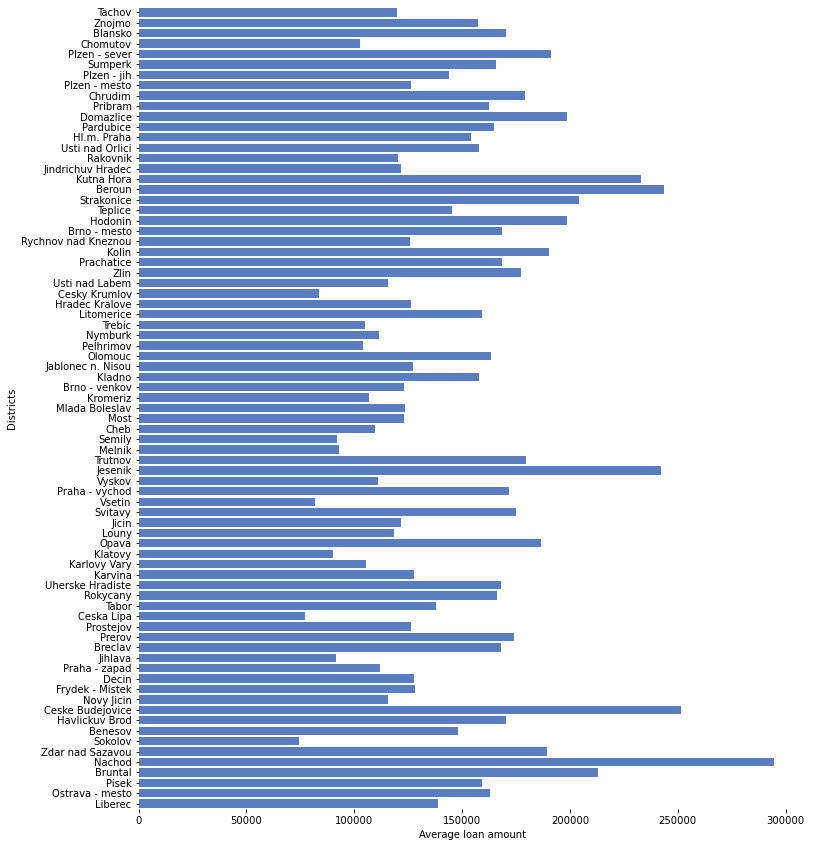

In [358]:
import seaborn as sns
fig, ax1 = plt.subplots(figsize=(10,12))
fig.tight_layout()
fig.subplots_adjust(top=0.96)

# plot the average loan amount per district
sns.barplot(x=avg_loan_amount_list, y=district_name_list , color="b", ax=ax1)
ax1.set(ylabel='Districts', xlabel='Average loan amount')
sns.despine(left=True, bottom=True,ax=ax1)

In [417]:
from pyspark.sql.functions import to_date
loan_df = spark.read.csv('loan.csv',inferSchema=True,header=True,sep=';')
loan_df = loan_df.select('loan_id','account_id',to_date('date','yyyy-MM-dd').alias('loan_date'),'amount','duration','payments',
                        'status')
loan_df.printSchema()

root
 |-- loan_id: integer (nullable = true)
 |-- account_id: integer (nullable = true)
 |-- loan_date: date (nullable = true)
 |-- amount: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- payments: double (nullable = true)
 |-- status: string (nullable = true)



In [597]:
from pyspark.sql.functions import when, col
# convert status_loan of 'A' and 'C' (good borrowers) to 1 and 'B' and 'D' (bad borrowers) to 0
loan_df = loan_df.withColumn('status', when((col('status')=='A')|(col('status')=='C'),1).otherwise(0))

In [598]:
account_df = spark.read.csv('account.csv',inferSchema=True,sep=';',header=True)
account_df = account_df.select(['account_id','district_id','frequency',to_date(account_df.date, 'yyyy-MM-dd').alias('acc_date')])
account_df

DataFrame[account_id: int, district_id: int, frequency: string, acc_date: date]

In [599]:
district_df

DataFrame[district_id: int, A2: string, A3: string, A4: int, A5: int, A6: int, A7: int, A8: int, A9: int, A10: double, A11: int, A12: double, A13: double, A14: int, A15: int, A16: int]

In [600]:
loan_account_district_df = loan_df.join(account_df,'account_id').join(district_df,'district_id')
loan_account_district_df

DataFrame[district_id: int, account_id: int, loan_id: int, loan_date: date, amount: int, duration: int, payments: double, status: int, frequency: string, acc_date: date, A2: string, A3: string, A4: int, A5: int, A6: int, A7: int, A8: int, A9: int, A10: double, A11: int, A12: double, A13: double, A14: int, A15: int, A16: int]

In [601]:
loan_account_district_df.select(['district_id','account_id','loan_id','acc_date','loan_date']).show(n=10)

+-----------+----------+-------+----------+----------+
|district_id|account_id|loan_id|  acc_date| loan_date|
+-----------+----------+-------+----------+----------+
|          1|         2|   4959|1993-02-26|1994-01-05|
|         21|        19|   4961|1995-04-07|1996-04-29|
|         68|        25|   4962|1996-07-28|1997-12-08|
|         20|        37|   4967|1997-08-18|1998-10-14|
|         19|        38|   4968|1997-08-08|1998-04-19|
|         16|        67|   4973|1994-10-19|1996-05-02|
|         74|        97|   4986|1996-05-05|1997-08-10|
|         44|       103|   4988|1996-03-10|1997-12-06|
|         21|       105|   4989|1997-07-10|1998-12-05|
|         36|       110|   4990|1996-07-17|1997-09-08|
+-----------+----------+-------+----------+----------+
only showing top 10 rows



In [602]:
from pyspark.sql.functions import datediff, col
loan_date_df = loan_account_district_df.select('loan_date')
acc_date_df= loan_account_district_df.select('acc_date')
# calculate the days between the account opening and the loan grant, use as feature for classification
loan_account_district_df = loan_account_district_df.withColumn('days_btwn_acc_loan',datediff(col('loan_date'), col('acc_date')))
# rename the columns I will use for features later on
loan_account_district_df = loan_account_district_df.withColumnRenamed('A4','number_of_residents').withColumnRenamed('A11','average_salary')\
                        .withColumnRenamed('A14','entepreneur_rate')

In [610]:
loan_account_district_df.select(['account_id','A15','A16','number_of_residents']).show(n=10)

+----------+-----+-----+-------------------+
|account_id|  A15|  A16|number_of_residents|
+----------+-----+-----+-------------------+
|         2|85677|99107|            1204953|
|        19| 2299| 2354|             103347|
|        25| 5623| 5887|             228848|
|        37| 1563| 1542|              70646|
|        38|  999| 1099|              51428|
|        67| 1874| 1913|              93931|
|        97|18782|18347|             323870|
|       103| 2166| 2325|             105606|
|       105| 2299| 2354|             103347|
|       110| 5796| 6132|             159617|
+----------+-----+-----+-------------------+
only showing top 10 rows



In [594]:
from pyspark.sql.functions import isnan, when, count, col
# find missing values of loan, account, district tables
loan_account_district_df.select([count(when((col(c).isNull()), c)).alias(c) for c,c_type in loan_account_district_df.dtypes ]).show()

+-----------+----------+-------+---------+------+--------+--------+------+---------+--------+---+---+-------------------+---+---+---+---+---+---+--------------+---+---+----------------+---+---+------------------+
|district_id|account_id|loan_id|loan_date|amount|duration|payments|status|frequency|acc_date| A2| A3|number_of_residents| A5| A6| A7| A8| A9|A10|average_salary|A12|A13|entepreneur_rate|A15|A16|days_btwn_acc_loan|
+-----------+----------+-------+---------+------+--------+--------+------+---------+--------+---+---+-------------------+---+---+---+---+---+---+--------------+---+---+----------------+---+---+------------------+
|          0|         0|      0|        0|     0|       0|       0|     0|        0|       0|  0|  0|                  0|  0|  0|  0|  0|  0|  0|             0|  0|  0|               0|  0|  0|                 0|
+-----------+----------+-------+---------+------+--------+--------+------+---------+--------+---+---+-------------------+---+---+---+---+---+---+---

In [511]:
# find the number of missing values for each column of trans_df
trans_df.select([count(when( col(c).isNull(), c)).alias(c) for c,c_type in trans_df.dtypes]).show()

+--------+----------+----+----+---------+------+-------+--------+------+------+-------+
|trans_id|account_id|date|type|operation|amount|balance|k_symbol|branch|  bank|account|
+--------+----------+----+----+---------+------+-------+--------+------+------+-------+
|       0|         0|3141|   0|   183126|     0|      0|  535359|     0|782875|      0|
+--------+----------+----+----+---------+------+-------+--------+------+------+-------+



In [612]:
# find mean unemployment rate and crime rate for years '95 '96 and select the some features from district table
from pyspark.sql.functions import col,lit
loan_account_district_df = loan_account_district_df.select(
    'account_id','days_btwn_acc_loan','number_of_residents','average_salary','entepreneur_rate','status',
    ((col('A12')+col('A13'))/lit(2)).alias('average_unemployment_rate'),
    ((col('A15')+col('A16'))/lit(2)/col('number_of_residents')).alias('average_crime_rate'))
loan_account_district_df.show(n=10)

+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+
|account_id|days_btwn_acc_loan|number_of_residents|average_salary|entepreneur_rate|status|average_unemployment_rate|  average_crime_rate|
+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+
|         2|               313|            1204953|         12541|             167|     1|                    0.315| 0.07667684963645885|
|        19|               388|             103347|          9104|             123|     0|                    1.785|0.022511538796481757|
|        25|               498|             228848|          9893|              96|     1|        4.359999999999999|0.025147696287492135|
|        37|               422|              70646|          8547|             120|     0|                     3.12|0.021975766497749342|
|        38|               254|   

In [627]:
order_df = spark.read.csv('order.csv',inferSchema=True,header=True,sep=';')
order_df.show(n=5)

+--------+----------+-------+----------+------+--------+
|order_id|account_id|bank_to|account_to|amount|k_symbol|
+--------+----------+-------+----------+------+--------+
|   29401|         1|     YZ|  87144583|2452.0|    SIPO|
|   29402|         2|     ST|  89597016|3372.7|    UVER|
|   29403|         2|     QR|  13943797|7266.0|    SIPO|
|   29404|         3|     WX|  83084338|1135.0|    SIPO|
|   29405|         3|     CD|  24485939| 327.0|    null|
+--------+----------+-------+----------+------+--------+
only showing top 5 rows



In [629]:
# calculate average order amount from table order
order_loan_account_district_df = loan_account_district_df.join(order_df.groupBy('account_id').agg(mean('amount').alias('average_order_amount')),'account_id')
order_loan_account_district_df.show(n=5)

+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+--------------------+
|account_id|days_btwn_acc_loan|number_of_residents|average_salary|entepreneur_rate|status|average_unemployment_rate|  average_crime_rate|average_order_amount|
+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+--------------------+
|         2|               313|            1204953|         12541|             167|     1|                    0.315| 0.07667684963645885|             5319.35|
|        19|               388|             103347|          9104|             123|     0|                    1.785|0.022511538796481757|              2523.2|
|        25|               498|             228848|          9893|              96|     1|        4.359999999999999|0.025147696287492135|             2653.55|
|        37|               422|              7

In [637]:
trans_df.columns

['trans_id',
 'account_id',
 'date',
 'type',
 'operation',
 'amount',
 'balance',
 'k_symbol',
 'branch',
 'bank',
 'account']

In [643]:
# from trans table calculate the average amount and balance per account_id
trans_order_loan_account_district_df = order_loan_account_district_df.join(trans_df.select(
    'account_id','amount','balance').groupBy('account_id').agg(mean('amount').alias('average_trans_amount'),mean('balance').alias('average_trans_balance')),'account_id')
trans_order_loan_account_district_df.show(n=5)

+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+--------------------+--------------------+---------------------+
|account_id|days_btwn_acc_loan|number_of_residents|average_salary|entepreneur_rate|status|average_unemployment_rate|  average_crime_rate|average_order_amount|average_trans_amount|average_trans_balance|
+----------+------------------+-------------------+--------------+----------------+------+-------------------------+--------------------+--------------------+--------------------+---------------------+
|         2|               313|            1204953|         12541|             167|     1|                    0.315| 0.07667684963645885|             5319.35|   6593.125523012553|   36540.780334728035|
|        19|               388|             103347|          9104|             123|     0|                    1.785|0.022511538796481757|              2523.2|   5199.775577557756|   16253.0693

In [687]:
features = trans_order_loan_account_district_df

In [ ]:
features.columns

In [650]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['account_id',
 'days_btwn_acc_loan',
 'number_of_residents',
 'average_salary',
 'entepreneur_rate',
 'status',
 'average_unemployment_rate',
 'average_crime_rate',
 'average_order_amount',
 'average_trans_amount',
 'average_trans_balance'], outputCol='features')

In [655]:
output = assembler.transform(features)

In [659]:
from pyspark.ml.feature import StringIndexer

In [660]:
indexer = StringIndexer(inputCol='status',outputCol='statusIndex')

In [663]:
output_fixed = indexer.fit(output).transform(output)

In [665]:
output_fixed.printSchema()

root
 |-- account_id: integer (nullable = true)
 |-- days_btwn_acc_loan: integer (nullable = true)
 |-- number_of_residents: integer (nullable = true)
 |-- average_salary: integer (nullable = true)
 |-- entepreneur_rate: integer (nullable = true)
 |-- status: integer (nullable = false)
 |-- average_unemployment_rate: double (nullable = true)
 |-- average_crime_rate: double (nullable = true)
 |-- average_order_amount: double (nullable = true)
 |-- average_trans_amount: double (nullable = true)
 |-- average_trans_balance: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- statusIndex: double (nullable = false)



In [666]:
final_features = output_fixed.select('features','statusIndex')

In [667]:
train_data, test_data = final_features.randomSplit([0.7,0.3])

In [670]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier

In [671]:
from pyspark.ml import Pipeline

In [673]:
dtc = DecisionTreeClassifier(labelCol='statusIndex', featuresCol ='features')
gbt = GBTClassifier(labelCol='statusIndex', featuresCol ='features')
rfc = RandomForestClassifier(labelCol='statusIndex', featuresCol ='features')

In [675]:
dtc_model = dtc.fit(train_data)
gbt_model = gbt.fit(train_data)
rfc_model = rfc.fit(train_data)

In [678]:
dtc_preds = dtc_model.transform(test_data)
gbt_preds = gbt_model.transform(test_data)
rfc_preds = rfc_model.transform(test_data)

In [679]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [680]:
my_binary_eval = BinaryClassificationEvaluator(labelCol='statusIndex')

In [682]:
print('DTC')
print(my_binary_eval.evaluate(dtc_preds))

DTC
1.0


In [689]:
my_binary_eval_1 = BinaryClassificationEvaluator(labelCol='statusIndex',
                                                rawPredictionCol='prediction')
print('GBT')
print(my_binary_eval_1.evaluate(gbt_preds))

GBT
1.0


In [684]:
print('RFC')
print(my_binary_eval.evaluate(rfc_preds))

RFC
1.0
